In [3]:
from tarfile import data_filter

import pandas as pd
import numpy as np
import importlib
from datetime import datetime
import matplotlib.pyplot as plt
from dask.dataframe import read_csv
from matplotlib.pyplot import xticks
from numpy.ma.core import cumsum
from pandas.core.interchange.dataframe_protocol import DataFrame
from ply.cpp import xrange
from pygments.lexer import bygroups

import volpy_func_lib as vp
import load_clean_lib
import table_lib

from datetime import datetime
from volpy_func_lib import load_forward_price

In [4]:
importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)

<module 'table_lib' from 'D:\\Professionelt\\Code\\volpy\\table_lib.py'>

In [5]:
profile = "Mads"
om_folder = "i2s1_full_v2"
input_dir = load_clean_lib.volpy_output_dir(profile, om_folder)

sum_df = pd.read_csv(f"{input_dir}/summary_dly.csv")
sum_df["date"] = pd.to_datetime(sum_df["date"])
sum_df[f"return_next"] = sum_df[f"return"].shift(-1)

od_raw = pd.read_csv(f"{input_dir}/od_raw.csv")
od_raw['optionid'] = od_raw['optionid'].astype(int)
od_raw["date"] = pd.to_datetime(od_raw["date"])

In [6]:
# sum_df["Stock_change"] = sum_df["close"].diff()

In [7]:
# sum_df = sum_df[sum_df["ticker"] == "SPX"]
# od_raw = od_raw[od_raw["ticker"] == "SPX"]

price_str = "mid"
IV_type = "om"
od_raw['price'] = od_raw[price_str]

In [8]:
od_hl = od_raw.merge(
    sum_df[['ticker', 'date', 'high days', 'low days']],
    on=['ticker', 'date'],
    how='left'
)

# Create two new columns 'high' and 'low'
od_hl['low'] = od_hl['days'] == od_hl['low days']
od_hl['high'] = od_hl['days'] == od_hl['high days']
od_hl = od_hl[(od_hl['low']) | (od_hl['high'])]
od_hl = od_hl.sort_values(by=['ticker', 'date'], ascending=True)

In [9]:
od_hl["moneyness"] = np.log(od_hl["K"]/od_hl["F"])
od_hl["abs(moneyness)"] = np.abs(od_hl["moneyness"])

In [10]:
# Compute F_high and F_low
f_low_values = od_hl[od_hl["low"]].groupby(['ticker', 'date'])['F'].first().reset_index()
f_high_values = od_hl[od_hl["high"]].groupby(['ticker', 'date'])['F'].first().reset_index()

# Rename the columns before merging
f_low_values.rename(columns={'F': 'F_low'}, inplace=True)
f_high_values.rename(columns={'F': 'F_high'}, inplace=True)

# Merge into sum_df
sum_df = sum_df.merge(f_low_values, on=['ticker', 'date'], how='left')
sum_df = sum_df.merge(f_high_values, on=['ticker', 'date'], how='left')

In [11]:
od_hl["IV"] = od_hl[f"IV_{IV_type}"]

In [12]:
from scipy.stats import norm

def process_options_ATM(df, low_high, cp_value, prefix):
    # Filter and sort options
    filtered = df[(df[low_high]) & (df['cp_flag'] == cp_value)].copy()
    filtered = filtered.sort_values(['ticker', 'date', 'abs(moneyness)'], 
                                   ascending=[True, True, True])
    filtered["T"] = filtered["days"]/365
    
    # Calculate d1 and delta
    filtered['d1'] = (np.log(filtered["F"] / filtered["K"]) + 0.5 * filtered["IV"] ** 2 * filtered["T"]) / (filtered["IV"] * np.sqrt(filtered["T"]))
    if cp_value == 'C':
        filtered['delta'] = norm.cdf(filtered['d1'])
    else:
        filtered['delta'] = norm.cdf(filtered['d1']) - 1

    # Create ranks and filter top 2
    filtered['rank'] = filtered.groupby(['ticker', 'date']).cumcount() + 1
    ranked = filtered[filtered['rank'] <= 2].copy()
    
    # Convert optionid to integer
    ranked['optionid'] = ranked['optionid'].astype(int)
    
    # Create pivot table
    pivot_df = ranked.pivot_table(
        index=['ticker', 'date'],
        columns='rank',
        values=['optionid', 'price', 'K', 'delta'],
        aggfunc='first'
    )
    
    # Flatten multi-index columns
    pivot_df.columns = [f'{prefix}_{col}_{rank}' for col, rank in pivot_df.columns]
    return pivot_df.reset_index()


# Define processing configurations
configs = [
    ('low', 'C', 'low_call'),
    ('low', 'P', 'low_put'),
    ('high', 'C', 'high_call'),
    ('high', 'P', 'high_put'),
]

# Process all combinations
pivoted_dfs = [process_options_ATM(od_hl, low_high, cp_flag, prefix) 
              for low_high, cp_flag, prefix in configs]

# Merge all results
for p_df in pivoted_dfs:
    sum_df = sum_df.merge(p_df, on=['ticker', 'date'], how='left')

In [13]:
# Create next price lookup
od_sorted = od_raw.sort_values(['optionid', 'date']).copy()
od_sorted['price_next'] = od_sorted.groupby('optionid')['price'].shift(-1)
next_price_lookup = od_sorted[['ticker', 'date', 'optionid', 'price_next']]

# Function to add next prices
def add_next_prices(sum_df, next_lookup):
    optionid_cols = [col for col in sum_df.columns if '_optionid' in col]
    
    for col in optionid_cols:
        prefix = col.replace('_optionid', '')
        # Merge next prices using optionid and current date
        sum_df = sum_df.merge(
            next_lookup.rename(columns={'optionid': col}),
            left_on=['ticker', 'date', col],
            right_on=['ticker', 'date', col],
            how='left'
        )
        # Clean up column names
        sum_df.rename(columns={'price_next': f'{prefix}_price_next'}, inplace=True)
    
    return sum_df

# Add next prices to all option columns
sum_df = add_next_prices(sum_df, next_price_lookup)

In [14]:
def T_day_interpolation(T1, T2, r1, r2, T = 30):
    return (r1 * np.abs(T2 - T) + r2 * np.abs(T1 - T)) / (np.abs(T2 - T) + np.abs(T1 - T))

In [15]:
sum_SPX = sum_df[sum_df["ticker"] == "SPX"].reset_index(drop=True)

In [16]:
# sum_df = sum_df[sum_df["#K"].isna() == False]

In [17]:
# Straddle
for low_high in ["low", "high"]:
    sum_SPX[f"r_{low_high}_straddle"] = (
            (sum_SPX[f"{low_high}_call_1_price_next"] + sum_SPX[f"{low_high}_put_1_price_next"]) / 
            (sum_SPX[f"{low_high}_call_price_1"]      + sum_SPX[f"{low_high}_put_price_1"])-1
    ).shift(1)

In [18]:
# Put and Call
for put_call in ["put", "call"]:
    for low_high in ["low", "high"]:
        sum_SPX[f"r_{low_high}_{put_call}"] = (
                sum_SPX[f"{low_high}_{put_call}_1_price_next"] / sum_SPX[f"{low_high}_{put_call}_price_1"] - 1
        ).shift(1)

In [19]:
# # Delta hedged Put and Call (%, current best)
# for put_call in ["put", "call"]:
#     for low_high in ["low", "high"]:
#         sum_SPX[f"r_delta_hedged_{low_high}_{put_call}"] = (
#             (sum_SPX[f"{low_high}_{put_call}_1_price_next"] - sum_SPX[f"{low_high}_{put_call}_price_1"] - sum_SPX[f"{low_high}_{put_call}_delta_1"] * sum_SPX[f"close"] * sum_SPX[f"return_next"]) / 
#             (sum_SPX[f"{low_high}_{put_call}_price_1"] + (sum_SPX[f"{low_high}_{put_call}_delta_1"] * sum_SPX[f"close"]))
#         ).shift(1)

In [20]:
# # Delta hedged Put and Call (new version)
# for put_call in ["put", "call"]:
#     for low_high in ["low", "high"]:
#         next_price = sum_SPX[f"{low_high}_{put_call}_1_price_next"] + sum_SPX[f"{low_high}_{put_call}_delta_1"] * sum_SPX[f"close"].shift(-1)
#         curr_price = sum_SPX[f"{low_high}_{put_call}_price_1"] + sum_SPX[f"{low_high}_{put_call}_delta_1"] * sum_SPX[f"close"]
# 
#         sum_SPX[f"r_delta_hedged_{low_high}_{put_call}"] = (next_price/curr_price - 1).shift(1)

In [21]:
# Put and Call (in USD)
for put_call in ["put", "call"]:
    for low_high in ["low", "high"]:
        sum_SPX[f"r_free_{low_high}_{put_call}"] = (
            sum_SPX[f"{low_high}_{put_call}_1_price_next"] - (1+sum_SPX[f"RF"]) * sum_SPX[f"{low_high}_{put_call}_price_1"]
        ).shift(1)

# Straddle        
for low_high in ["low", "high"]:
    sum_SPX[f"r_free_{low_high}_straddle"] = sum_SPX[f"r_free_{low_high}_put"] + sum_SPX[f"r_free_{low_high}_call"]

In [22]:
# Delta hedged Put and Call (in USD)
for put_call in ["put", "call"]:
    for low_high in ["low", "high"]:
        sum_SPX[f"r_free_delta_hedged_{low_high}_{put_call}"] = (
            sum_SPX[f"{low_high}_{put_call}_1_price_next"] - (1+sum_SPX[f"RF"]) * sum_SPX[f"{low_high}_{put_call}_price_1"] - 
            sum_SPX[f"{low_high}_{put_call}_delta_1"] * sum_SPX[f"close"] * (sum_SPX[f"return"].shift(-1) - sum_SPX[f"RF"]) # Delta hedge (self financed)
        ).shift(1)

# Delta hedged Straddle        
for low_high in ["low", "high"]:
    sum_SPX[f"r_free_delta_hedged_{low_high}_straddle"] = sum_SPX[f"r_free_delta_hedged_{low_high}_put"] + sum_SPX[f"r_free_delta_hedged_{low_high}_call"]

In [23]:
T1 = sum_SPX["low days"].shift(-1)
T2 = sum_SPX["high days"].shift(-1)

sum_SPX["r_30_straddle"] = T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX["r_low_straddle"], r2 = sum_SPX["r_high_straddle"])
sum_SPX["r_30_D_call"] = T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX["r_low_straddle"], r2 = sum_SPX["r_high_straddle"])
sum_SPX["r_30_straddle"] = T_day_interpolation(T1 = T1, T2 = T2, r1 = sum_SPX["r_low_straddle"], r2 = sum_SPX["r_high_straddle"])


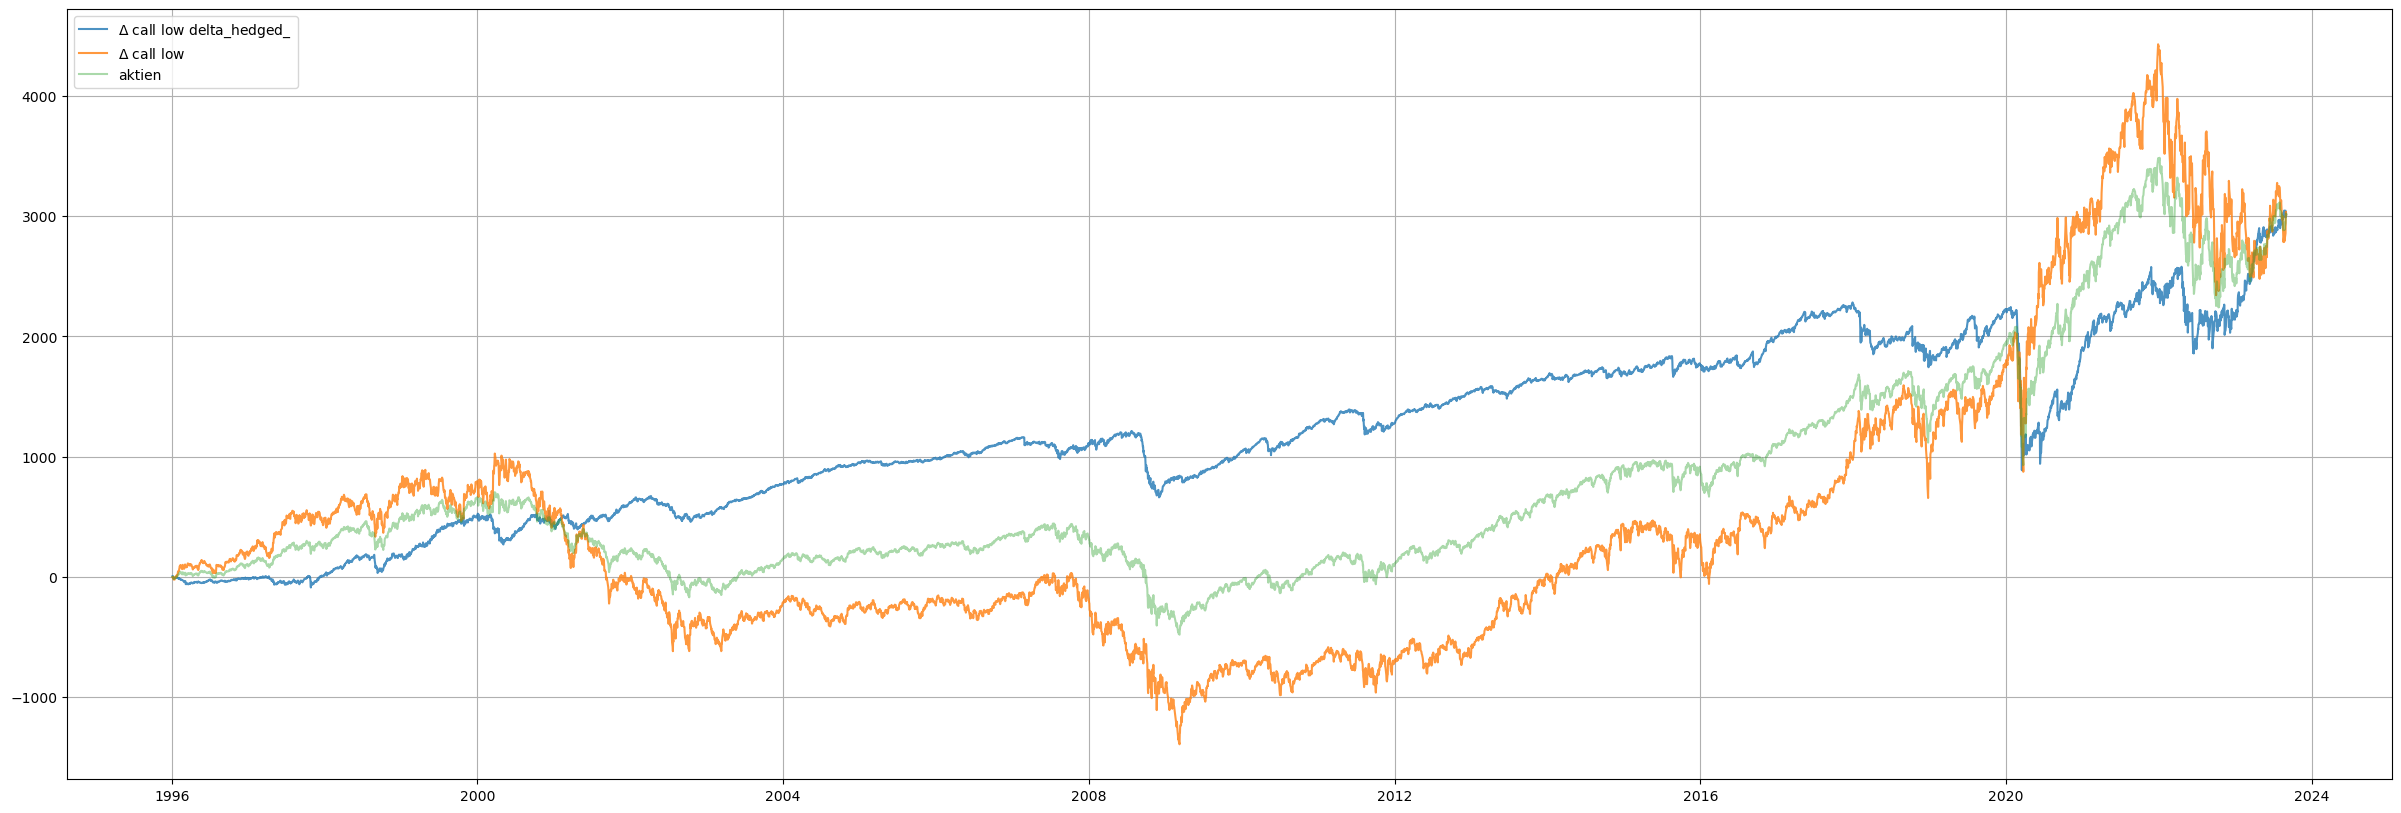

In [24]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX[f"close"].diff()-sum_SPX[f"close"].shift(1)*sum_SPX[f"RF"]).iloc[-1]

for low_high in ["low"]:
    for hedge in ["delta_hedged_", ""]:
        last_option_val = np.cumsum(sum_SPX[f"r_free_{hedge}{low_high}_{put_call}"]).iloc[-1]
        plt.plot(sum_SPX["date"], last_stock_val/last_option_val * np.cumsum(sum_SPX[f"r_free_{hedge}{low_high}_{put_call}"]),
             label=rf"$\Delta$ {put_call} " + low_high + " " + hedge, alpha=0.8)
plt.plot(sum_SPX["date"], np.cumsum(sum_SPX[f"close"].diff()-sum_SPX[f"close"].shift(1)*sum_SPX[f"RF"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()

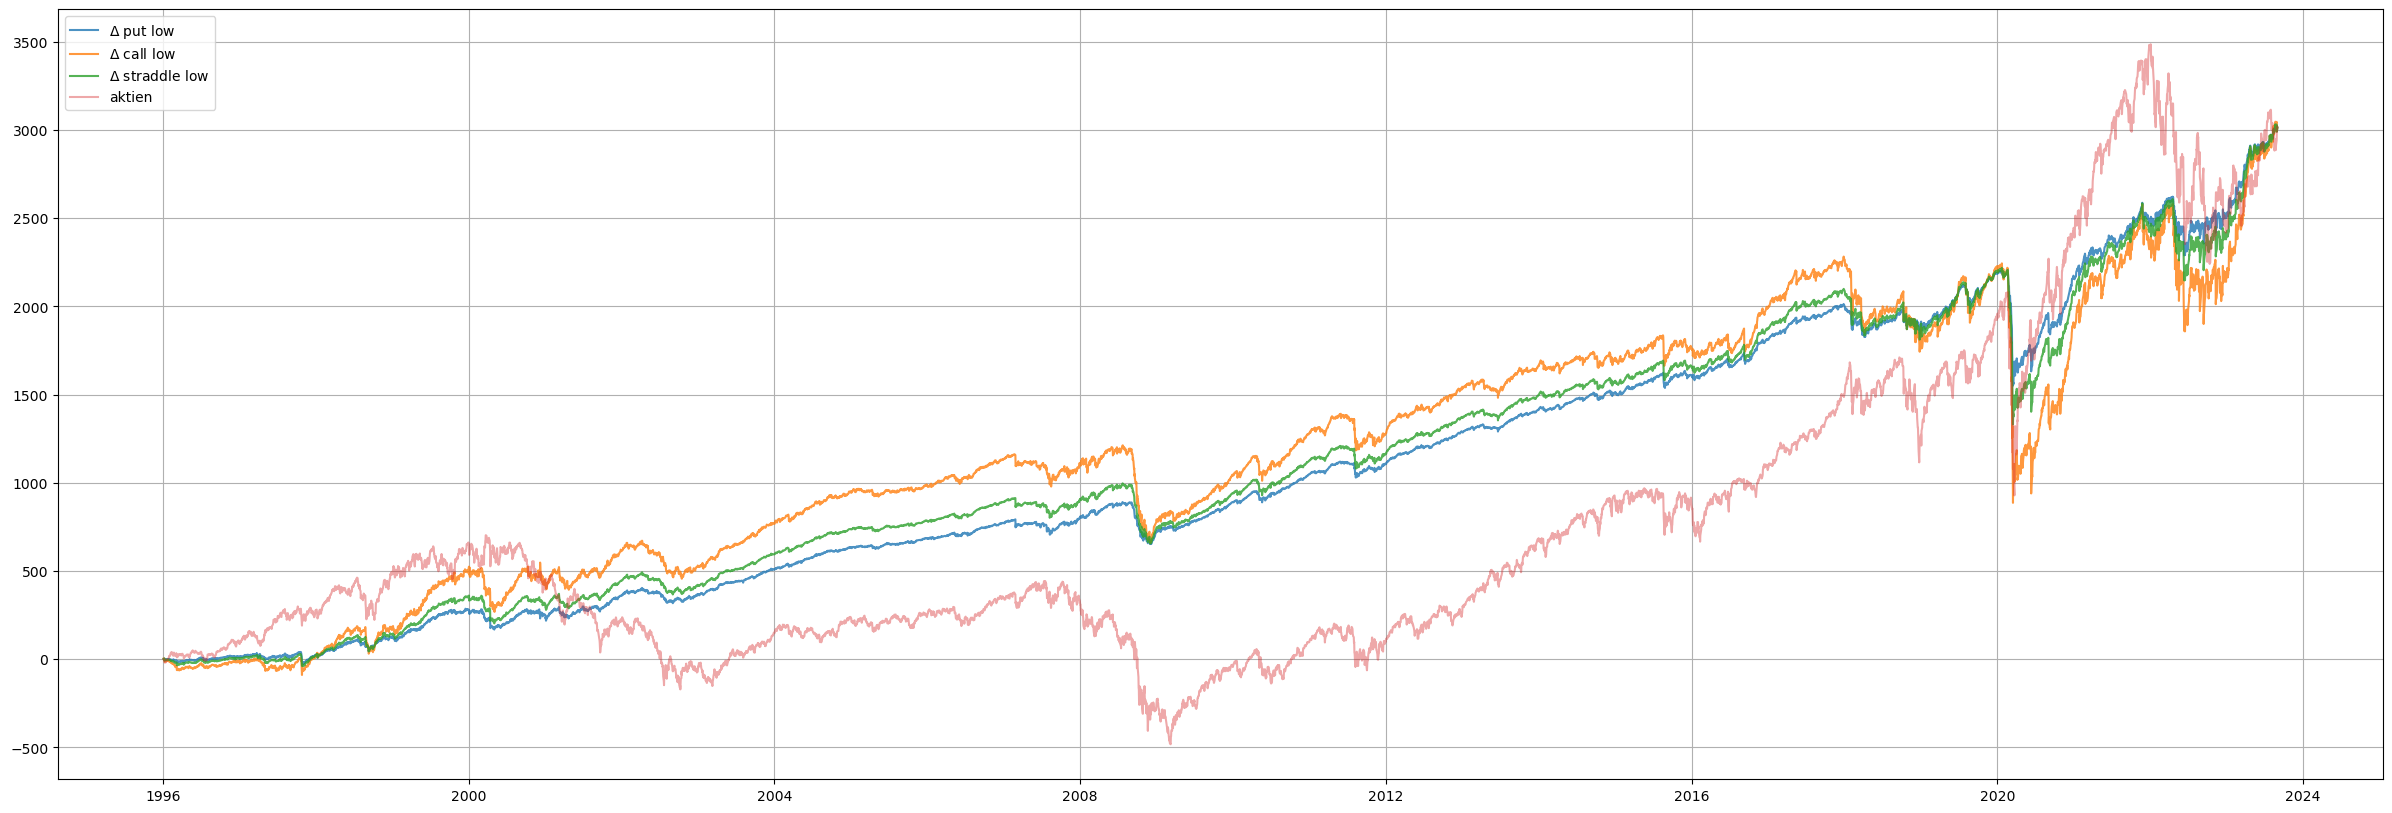

In [25]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX[f"close"].diff()-sum_SPX[f"close"].shift(1)*sum_SPX[f"RF"]).iloc[-1]
hedge_type = "delta_hedged_"

for low_high in ["low"]:
    for put_call in ["put", "call", "straddle"]:
        last_option_val = np.cumsum(sum_SPX[f"r_free_{hedge_type}{low_high}_{put_call}"]).iloc[-1]
        plt.plot(sum_SPX["date"], last_stock_val/last_option_val * np.cumsum(sum_SPX[f"r_free_{hedge_type}{low_high}_{put_call}"]),
             label=rf"$\Delta$ {put_call} " + low_high, alpha=0.8)
plt.plot(sum_SPX["date"], np.cumsum(sum_SPX[f"close"].diff()-sum_SPX[f"close"].shift(1)*sum_SPX[f"RF"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()

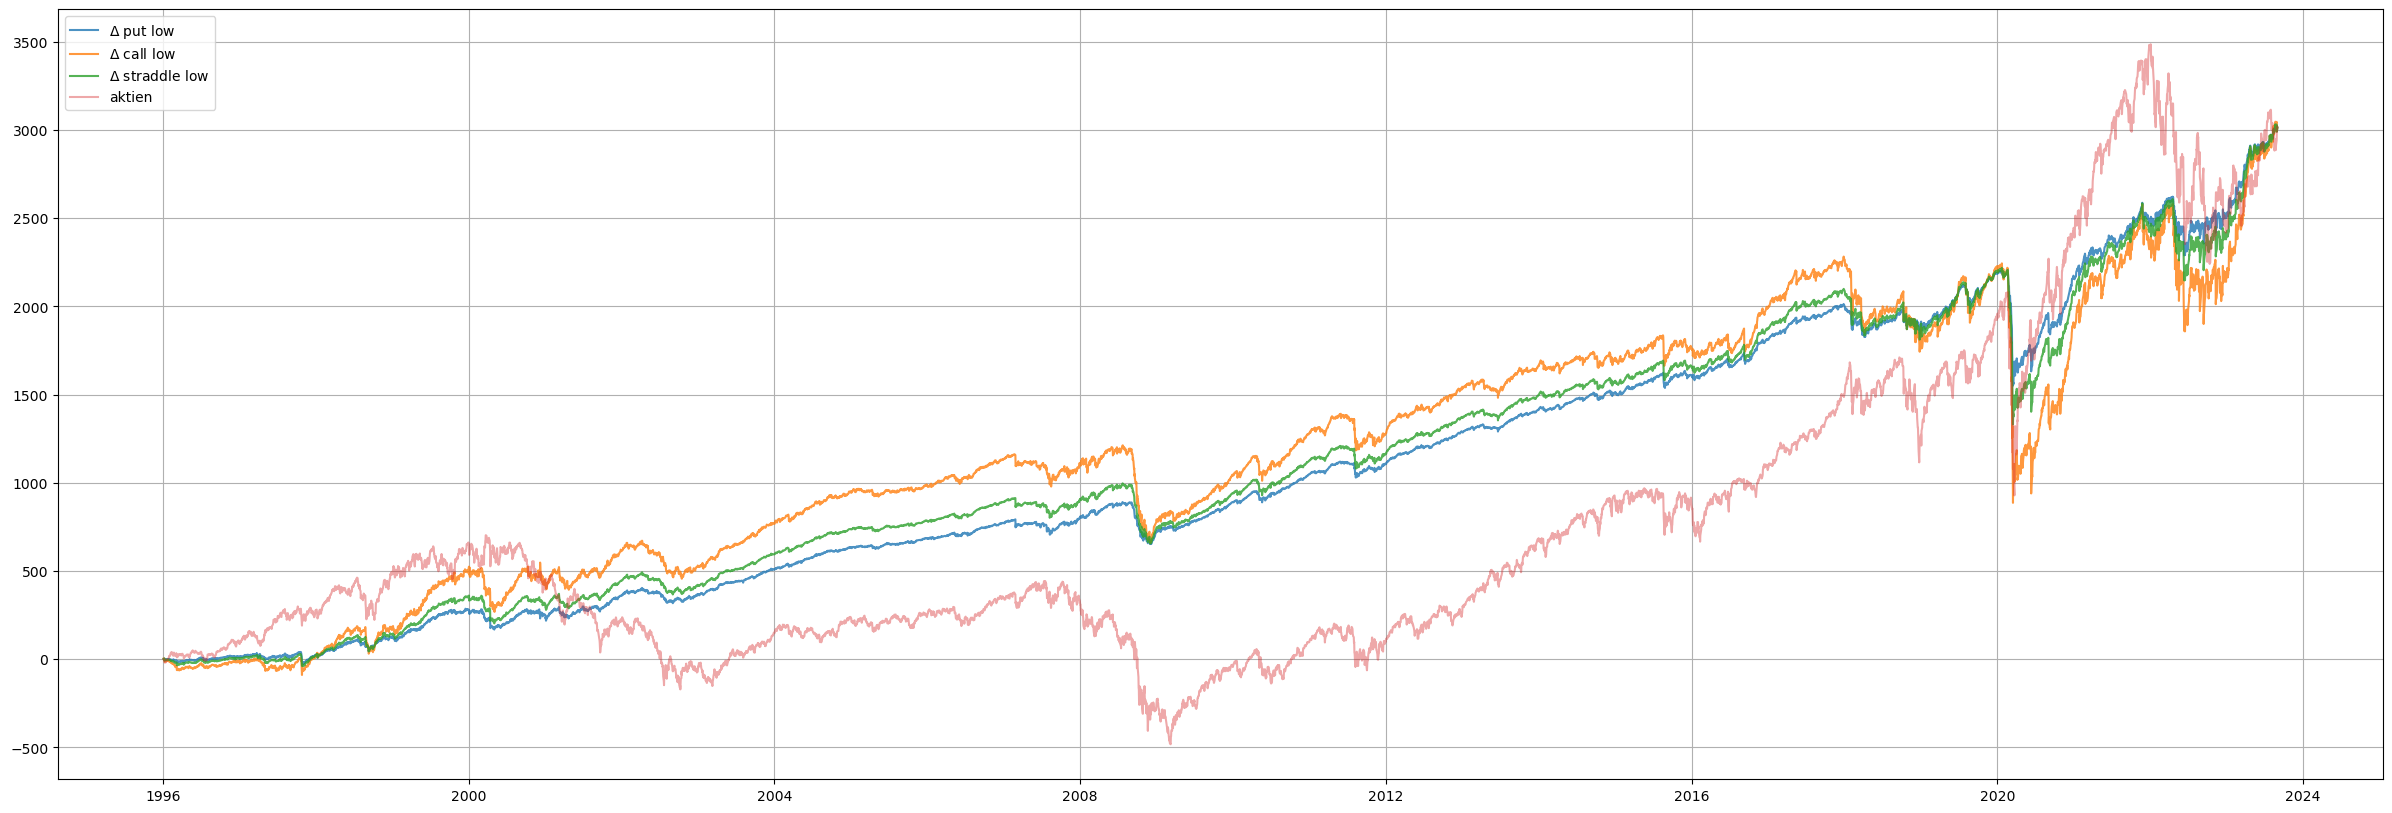

In [26]:
plt.figure(figsize=(30, 10))

last_stock_val = np.cumsum(sum_SPX[f"close"].diff()-sum_SPX[f"close"].shift(1)*sum_SPX[f"RF"]).iloc[-1]

for low_high in ["low"]:
    for put_call in ["put", "call", "straddle"]:
        last_option_val = np.cumsum(sum_SPX[f"r_free_delta_hedged_{low_high}_{put_call}"]).iloc[-1]
        plt.plot(sum_SPX["date"], last_stock_val/last_option_val * np.cumsum(sum_SPX[f"r_free_delta_hedged_{low_high}_{put_call}"]),
             label=rf"$\Delta$ {put_call} " + low_high, alpha=0.8)
plt.plot(sum_SPX["date"], np.cumsum(sum_SPX[f"close"].diff()-sum_SPX[f"close"].shift(1)*sum_SPX[f"RF"]),
    label="aktien", alpha=0.4)

plt.grid()
plt.legend()
plt.show()

In [27]:
plt.figure(figsize=(30, 10))

for low_high in ["low"]:
    plt.plot(sum_SPX["date"], np.cumsum(np.log10(1+sum_SPX[f"r_delta_hedged_{low_high}_put"])),
             label=r"$\Delta$ put " + low_high)
    plt.plot(sum_SPX["date"], np.cumsum(np.log10(1-sum_SPX[f"r_delta_hedged_{low_high}_call"])),
             label=r"$\Delta$ call " + low_high)
    plt.plot(sum_SPX["date"], np.cumsum(np.log10(1+sum_SPX[f"return"])),
             label="aktien")

plt.legend()
plt.show()

KeyError: 'r_delta_hedged_low_put'

<Figure size 3000x1000 with 0 Axes>

In [90]:
np.log10(10)

1.0

In [84]:
np.log1p(10)

2.3978952727983707

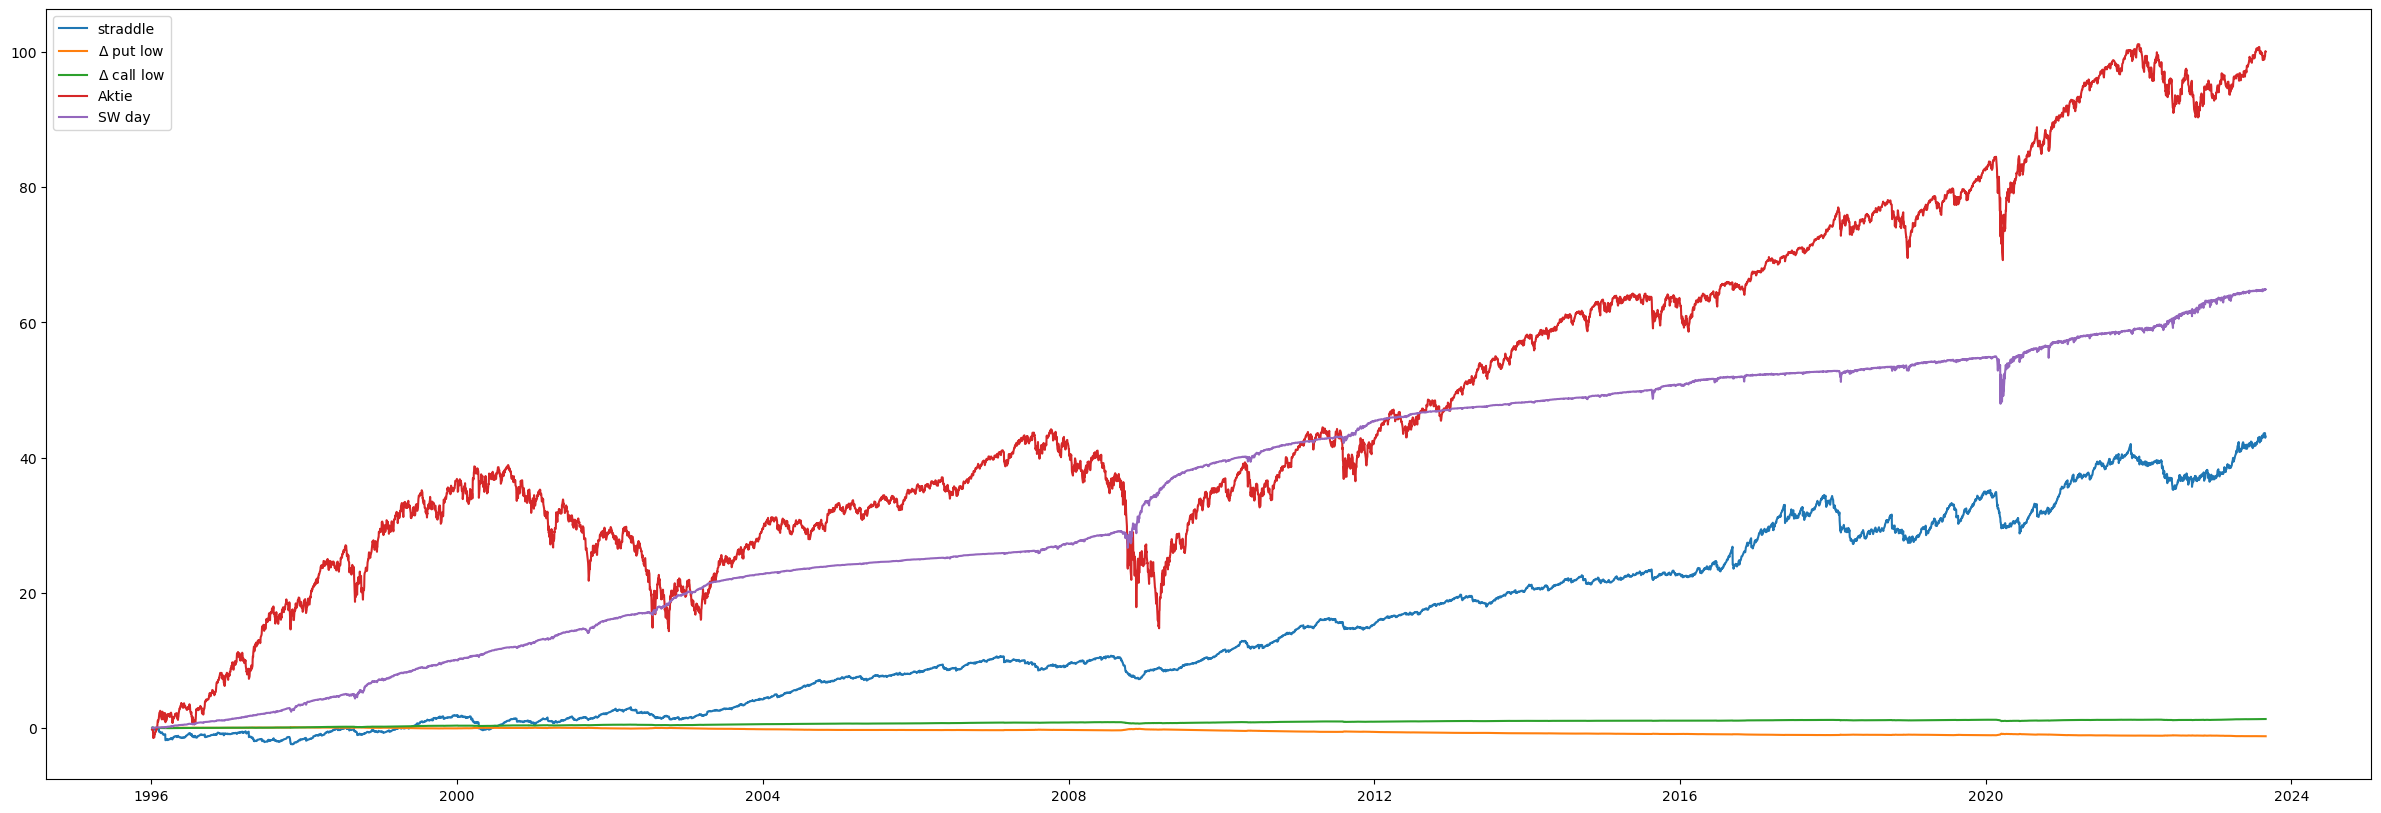

In [75]:
plt.figure(figsize=(30, 10))

plt.plot(sum_SPX["date"], -np.cumsum(sum_SPX[f"r_30_straddle"]), label="straddle")
# plt.plot(sum_SPX["date"], -np.cumsum(sum_SPX[f"r_30_straddle"]), label = 30)

for low_high in ["low"]:
    plt.plot(sum_SPX["date"], np.cumsum(np.log1p(-sum_SPX[f"r_delta_hedged_{low_high}_put"])),
             label=r"$\Delta$ put " + low_high)
    plt.plot(sum_SPX["date"], np.cumsum(np.log1p(-sum_SPX[f"r_delta_hedged_{low_high}_call"])),
             label=r"$\Delta$ call " + low_high)

plt.plot(sum_SPX["date"], 40 * np.cumsum(sum_SPX[f"return"]), label="Aktie")
plt.plot(sum_SPX["date"], np.cumsum(-sum_SPX[f"SW_day"] * 6), label="SW day")

plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


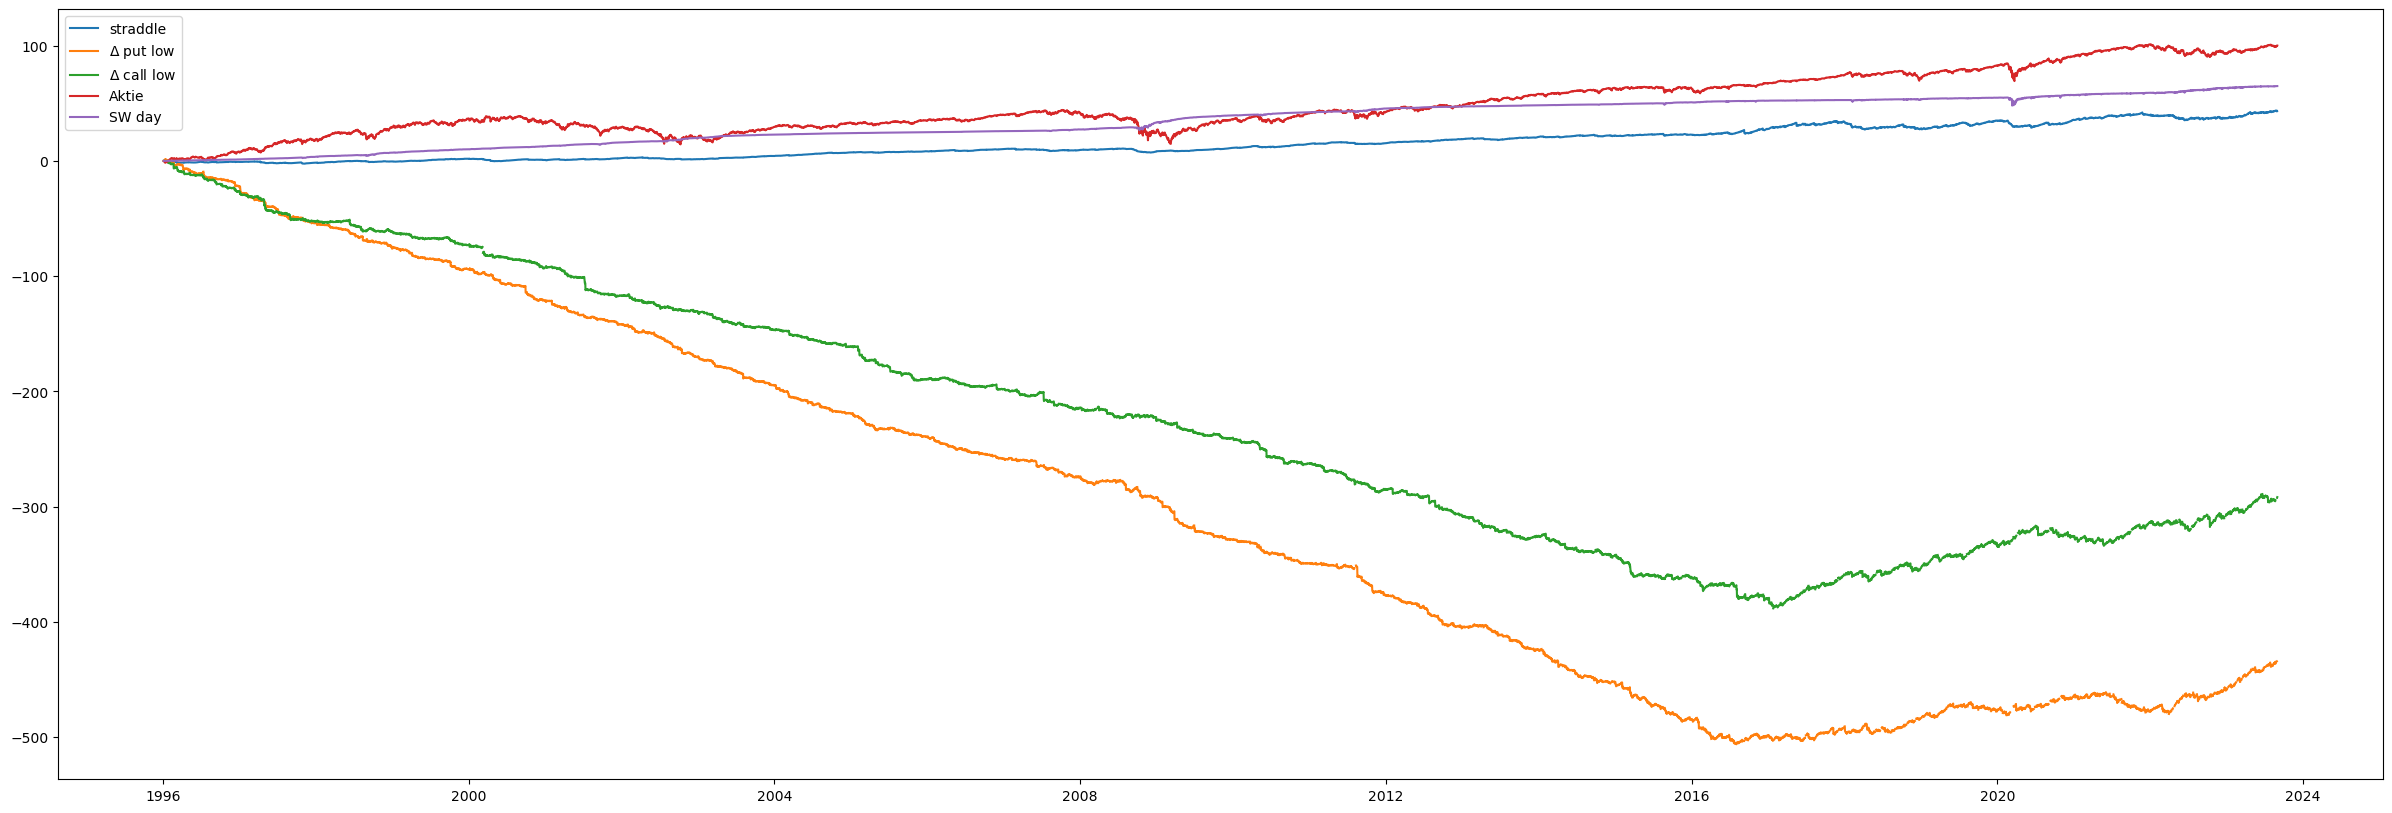

In [49]:
plt.figure(figsize=(30, 10))


plt.plot(sum_SPX["date"], -np.cumsum(sum_SPX[f"r_30_straddle"]), label = "straddle")
# plt.plot(sum_SPX["date"], -np.cumsum(sum_SPX[f"r_30_straddle"]), label = 30)

for low_high in ["low"]:
    plt.plot(sum_SPX["date"], np.cumsum(np.log1p(-sum_SPX[f"r_delta_hedged_{low_high}_put"])), label = r"$\Delta$ put " + low_high)
    plt.plot(sum_SPX["date"], np.cumsum(np.log1p(-sum_SPX[f"r_delta_hedged_{low_high}_call"])), label = r"$\Delta$ call " + low_high)

# plt.plot(sum_SPX["date"], -np.cumsum(sum_SPX[f"r_{low_high}_{put_call}"]), label = put_call + " " + low_high)

plt.plot(sum_SPX["date"], 40*np.cumsum(sum_SPX[f"return"]), label = "Aktie")

# plt.plot(sum_SPX["date"], -np.cumsum(sum_SPX[f"r_delta_hedged_low_put"]), label = put_call)

plt.plot(sum_SPX["date"], np.cumsum(-sum_SPX[f"SW_day"]*6), label = "SW day")

plt.legend()
plt.show()

In [52]:
# np.abs(T2 - T) / (np.abs(T2 - T) + np.abs(T1 - T))

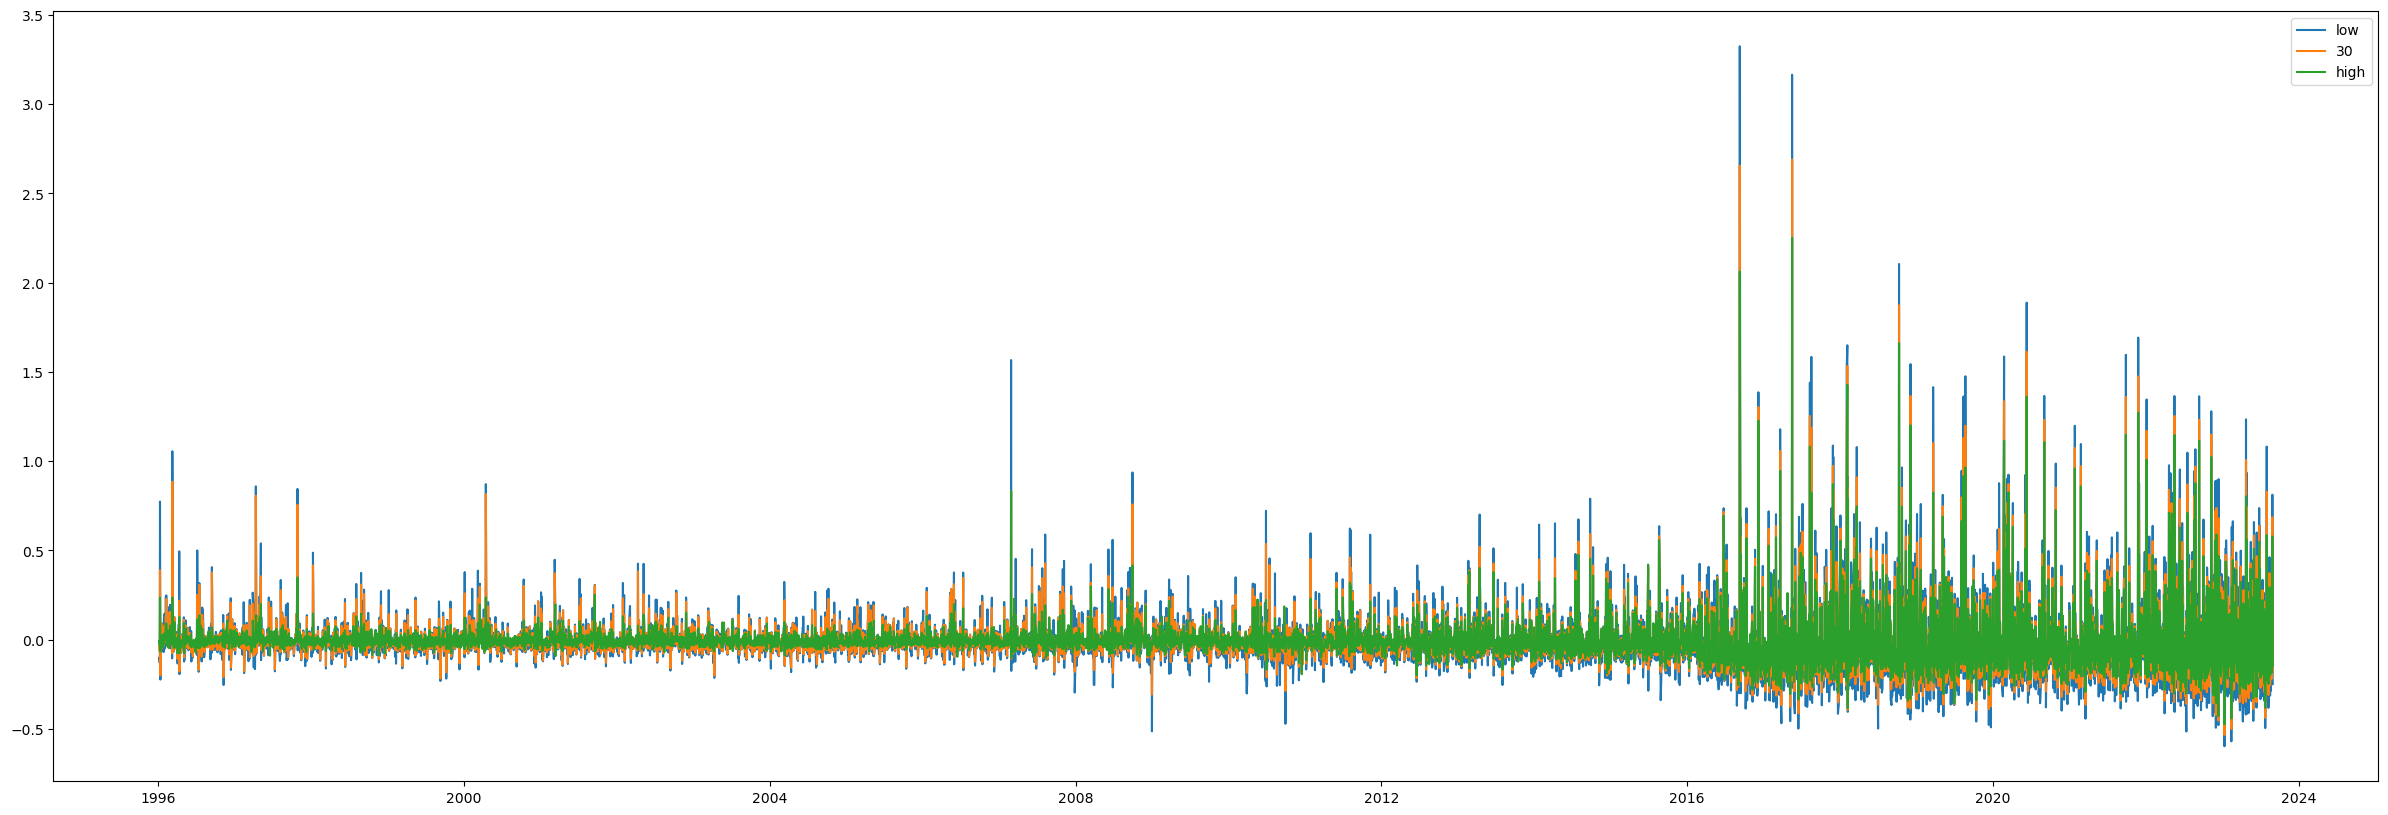

In [53]:
plt.figure(figsize=(30, 10))

for low_high in ["low", "30", "high"]:
    plt.plot(sum_SPX["date"], sum_SPX[f"r_{low_high}_straddle"], label = low_high)
plt. legend()

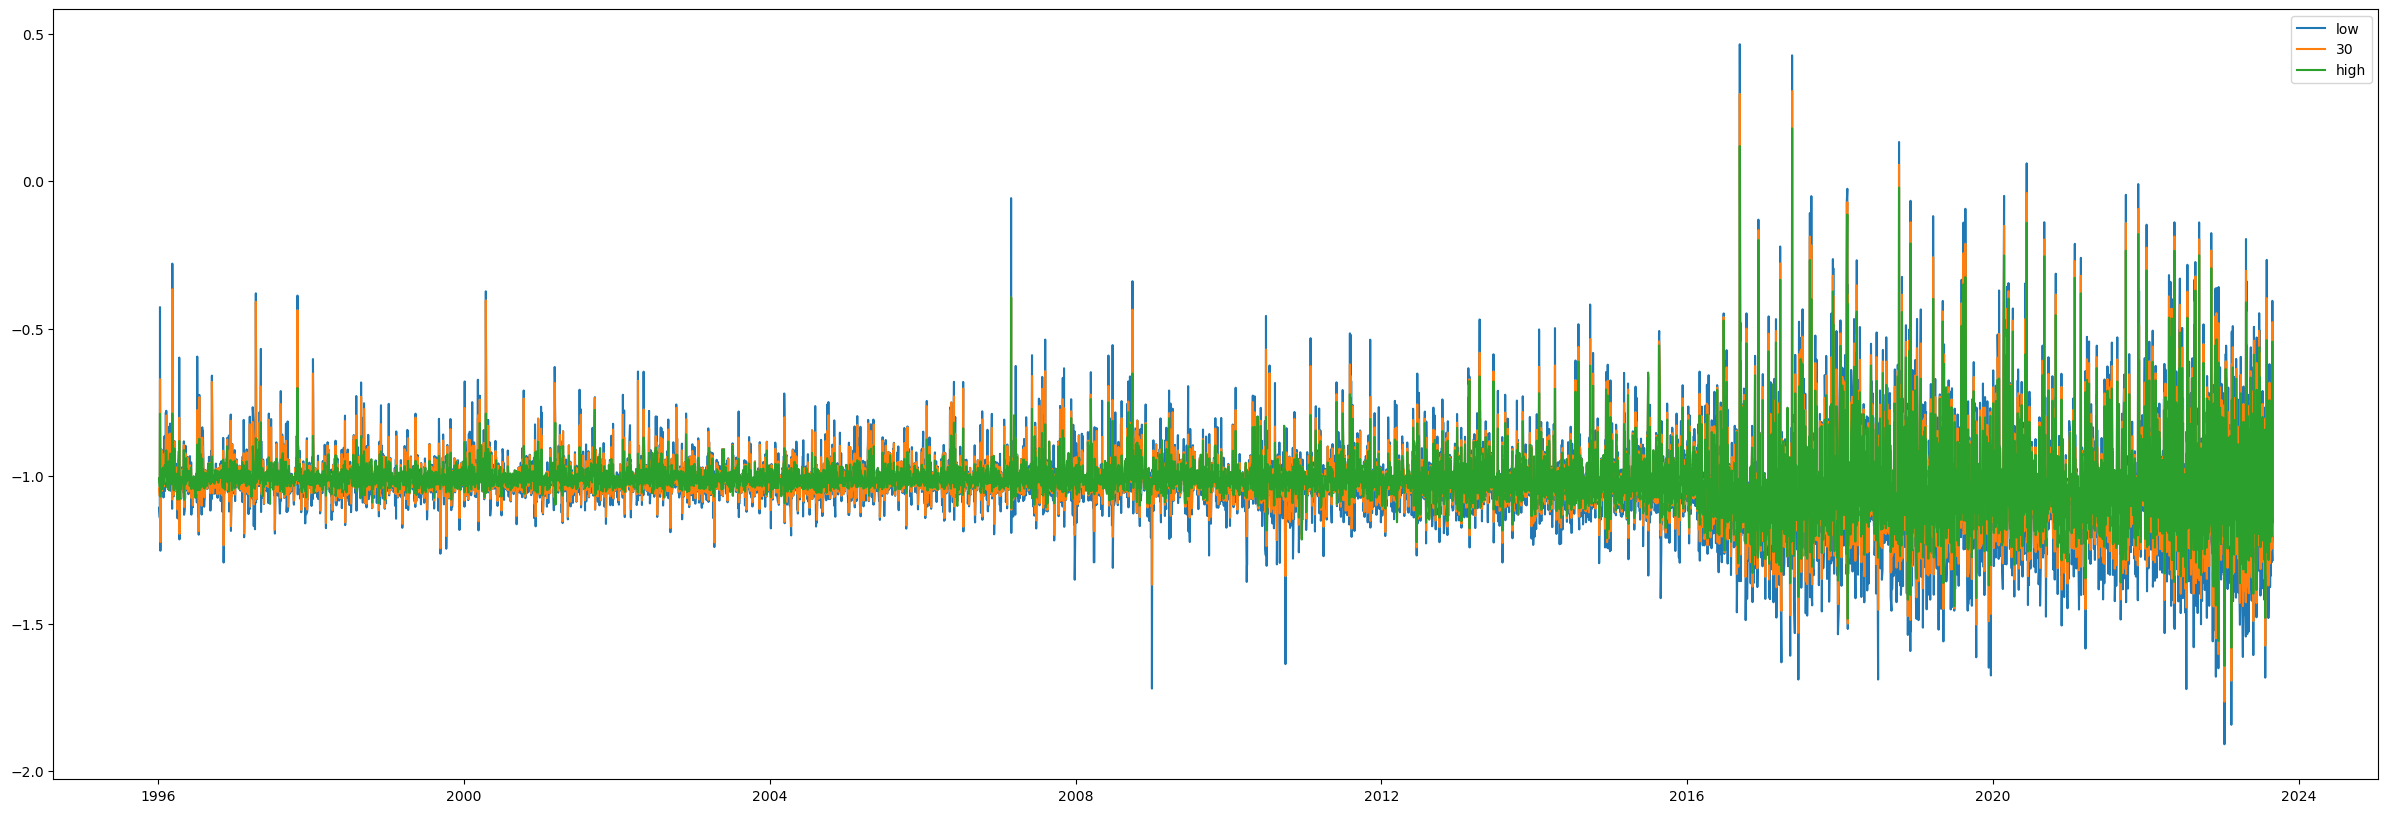

In [68]:
plt.figure(figsize=(30, 10))

for low_high in ["low", "30", "high"]:
    plt.plot(sum_SPX["date"], np.log1p(sum_SPX[f"r_{low_high}_straddle"])-1, label = low_high)
plt. legend()

In [35]:
print([f"{low_high} = {np.mean(sum_SPX[f"r_{low_high}_straddle"])}" for low_high in ["low", "high", "30"]])

['low = -0.008749284755233105', 'high = -0.0035984298358519946', '30 = -0.006006563782326231']


In [76]:
sum_SPX.columns

Index(['ticker', 'date', 'index', '#days', 'low days', 'high days', 'low #K',
       'high #K', '#K', 'low SW', 'high SW', 'Active', 'Inactive reason', 'RF',
       'RV', 'open', 'squared_return', 'SW_0_30', 'SW_m30_0', 'RV_m30_0',
       'SW_month', 'SW_month_ln_ret', 'SW_month_ln_ret_RF', 'SW_m1_29',
       'SW_0_29', 'SW_day', 'SW_day_RF', 'SW_day_ln_ret', 'SW_day_ln_ret_RF',
       'SW_sell', 'SW_buy', 'F_low', 'F_high', 'low_call_K_1', 'low_call_K_2',
       'low_call_optionid_1', 'low_call_optionid_2', 'low_call_price_1',
       'low_call_price_2', 'low_put_K_1', 'low_put_K_2', 'low_put_optionid_1',
       'low_put_optionid_2', 'low_put_price_1', 'low_put_price_2',
       'high_call_K_1', 'high_call_K_2', 'high_call_optionid_1',
       'high_call_optionid_2', 'high_call_price_1', 'high_call_price_2',
       'high_put_K_1', 'high_put_K_2', 'high_put_optionid_1',
       'high_put_optionid_2', 'high_put_price_1', 'high_put_price_2',
       'low_call_1_price_next', 'low_call_2_price_

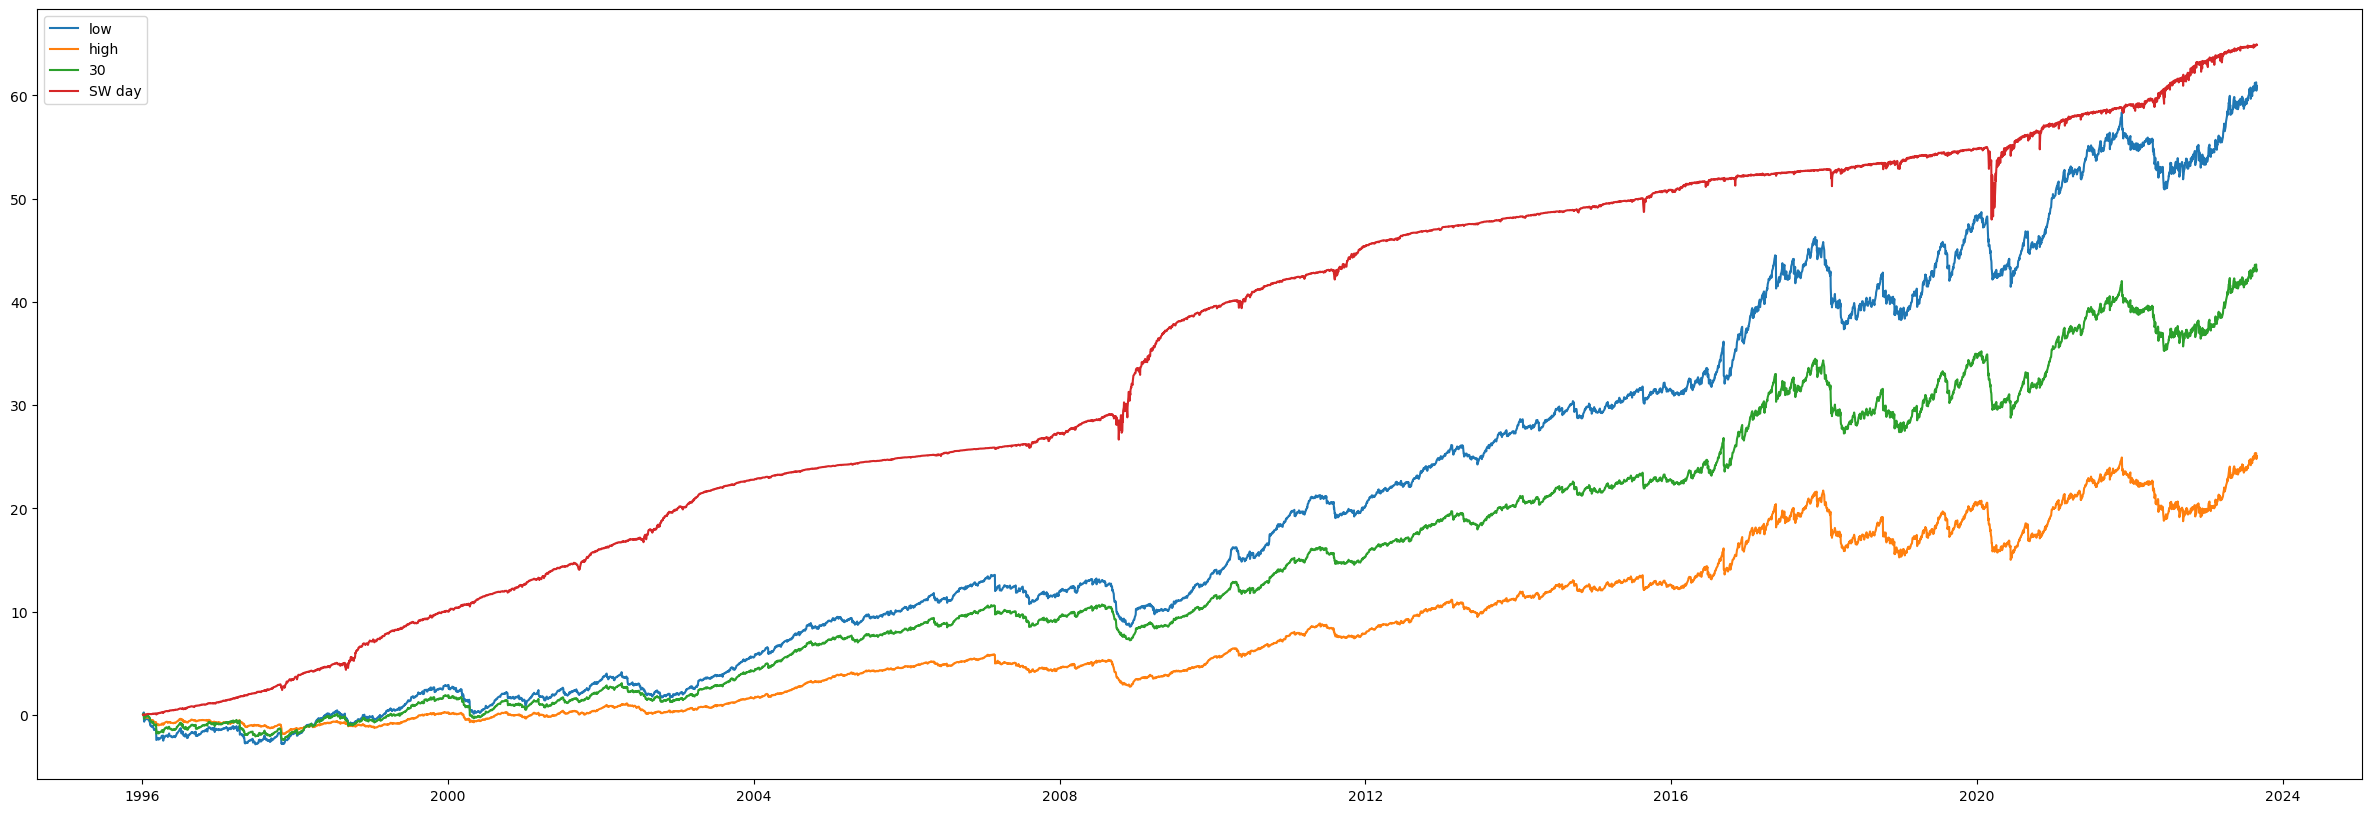

In [79]:
plt.figure(figsize=(30, 10))

for low_high in ["low", "high", "30"]:
    plt.plot(sum_SPX["date"], -np.cumsum(sum_SPX[f"r_{low_high}_straddle"]), label = low_high)
    
plt.plot(sum_SPX["date"], np.cumsum(-sum_SPX[f"SW_day"]*6), label = "SW day")

plt. legend()

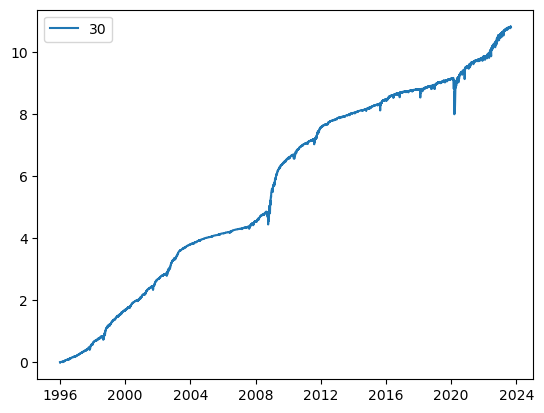

In [70]:
# for low_high in [""]:
plt.plot(sum_SPX["date"], np.cumsum(-sum_SPX[f"SW_day"]), label = low_high)
plt. legend()

In [42]:
sum_SPX

,ticker,date,index,#days,low days,high days,low #K,high #K,#K,low SW,...,high_put_price_1,high_put_price_2,low_call_1_price_next,low_call_2_price_next,low_put_1_price_next,low_put_2_price_next,high_call_1_price_next,high_call_2_price_next,high_put_1_price_next,high_put_2_price_next
0,SPX,1996-01-04,6963,6.0,16.0,44.0,23.0,24.0,23.5,0.020030,...,10.00,12.6250,3.3750,6.0000,7.1250,4.8125,7.8750,5.8125,10.250,13.2500
1,SPX,1996-01-05,6964,6.0,15.0,43.0,26.0,24.0,25.0,0.017916,...,10.25,8.2500,4.1875,7.0625,4.9375,3.1875,9.0000,12.2500,8.500,6.5625
2,SPX,1996-01-08,6965,6.0,12.0,40.0,20.0,24.0,22.0,0.016705,...,8.50,11.0000,0.9375,1.9375,15.2500,11.2500,4.8750,2.8750,16.750,20.3750
3,SPX,1996-01-09,6966,6.0,11.0,39.0,23.0,24.0,23.5,0.039954,...,11.50,14.0625,1.2500,0.5625,13.1875,18.7500,5.2500,4.0000,15.625,19.6250
4,SPX,1996-01-10,6967,6.0,10.0,38.0,21.0,25.0,23.0,0.033681,...,10.50,12.8125,6.0625,9.5000,3.0625,2.0625,11.4375,8.4375,7.750,9.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,SPX,2023-08-25,13921,42.0,4.0,5.0,119.0,126.0,122.5,0.013811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6959,SPX,2023-08-28,13922,42.0,2.0,3.0,112.0,182.0,147.0,0.019616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6960,SPX,2023-08-29,13923,42.0,2.0,3.0,189.0,175.0,182.0,0.022154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6961,SPX,2023-08-30,13924,42.0,2.0,6.0,160.0,136.0,148.0,0.022042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
sum_df[sum_df["ticker"] == "AMZN"]

,ticker,date,index,#days,low days,high days,low #K,high #K,#K,low SW,...,high_put_price_1,high_put_price_2,low_call_1_price_next,low_call_2_price_next,low_put_1_price_next,low_put_2_price_next,high_call_1_price_next,high_call_2_price_next,high_put_1_price_next,high_put_2_price_next
14402,AMZN,1997-11-19,14402,4.0,31.0,59.0,2.0,2.0,2.0,NaN,...,8.0625,5.2500,4.68750,7.5000,5.3750,3.0625,6.6250,8.8125,7.5000,4.8125
14403,AMZN,1997-11-20,14403,4.0,30.0,58.0,4.0,4.0,4.0,0.680781,...,7.5000,4.8125,4.18750,7.0000,5.6875,3.1875,6.0625,8.2500,7.8125,5.0625
14404,AMZN,1997-11-21,14404,4.0,29.0,57.0,4.0,5.0,4.5,0.683420,...,7.8125,5.0625,2.46875,4.6875,7.0000,4.1250,4.1875,6.2500,8.9375,6.1875
14405,AMZN,1997-11-24,14405,4.0,26.0,54.0,4.0,5.0,4.5,0.665685,...,6.1875,8.9375,4.18750,2.3125,4.2500,7.3125,6.0000,3.9375,6.3125,9.3125
14406,AMZN,1997-11-25,14406,4.0,25.0,53.0,6.0,5.0,5.5,0.681464,...,6.3125,3.8750,4.50000,2.3750,3.6875,6.5625,6.3125,9.3125,5.8125,3.3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20884,AMZN,2023-08-25,20884,14.0,14.0,21.0,45.0,75.0,60.0,0.075167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20885,AMZN,2023-08-28,20885,14.0,11.0,18.0,42.0,66.0,54.0,0.075164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20886,AMZN,2023-08-29,20886,14.0,10.0,17.0,42.0,67.0,54.5,0.065201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20887,AMZN,2023-08-30,20887,14.0,9.0,16.0,41.0,64.0,52.5,0.059496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
sum_df

,ticker,date,index,#days,low days,high days,low #K,high #K,#K,low SW,...,high_put_price_1,high_put_price_2,low_call_1_price_next,low_call_2_price_next,low_put_1_price_next,low_put_2_price_next,high_call_1_price_next,high_call_2_price_next,high_put_1_price_next,high_put_2_price_next
0,NDX,1996-01-04,0,5.0,16.0,44.0,30.0,23.0,26.5,0.095375,...,21.625,23.500,13.000,16.000,11.750,9.625,21.750,27.375,21.125,23.375
1,NDX,1996-01-05,1,5.0,15.0,43.0,29.0,27.0,28.0,0.083854,...,23.375,21.125,11.500,7.875,12.500,15.000,19.750,22.500,23.625,21.375
2,NDX,1996-01-08,2,5.0,12.0,40.0,27.0,28.0,27.5,0.093475,...,21.375,23.625,2.625,4.250,32.125,28.125,9.750,8.250,37.750,41.125
3,NDX,1996-01-09,3,5.0,11.0,39.0,26.0,25.0,25.5,0.155022,...,20.000,23.000,13.250,10.500,11.000,13.000,21.125,15.875,21.625,23.000
4,NDX,1996-01-10,4,5.0,10.0,38.0,28.0,29.0,28.5,0.144359,...,23.000,21.625,23.750,19.875,3.000,4.000,31.375,34.750,13.875,12.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20884,AMZN,2023-08-25,20884,14.0,14.0,21.0,45.0,75.0,60.0,0.075167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20885,AMZN,2023-08-28,20885,14.0,11.0,18.0,42.0,66.0,54.0,0.075164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20886,AMZN,2023-08-29,20886,14.0,10.0,17.0,42.0,67.0,54.5,0.065201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20887,AMZN,2023-08-30,20887,14.0,9.0,16.0,41.0,64.0,52.5,0.059496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
np.sum(sum_df.isna(), axis=0)

ticker                        0
date                          0
index                         0
#days                         0
low days                      0
                          ...  
low_put_2_price_next      11253
high_call_1_price_next    11252
high_call_2_price_next    11251
high_put_1_price_next     11252
high_put_2_price_next     11251
Length: 65, dtype: int64

In [33]:
np.sum(sum_df[['low_call_1_price_next', 'low_call_2_price_next', 'low_put_1_price_next', 'low_put_2_price_next','high_call_1_price_next', 'high_call_2_price_next', 'high_put_1_price_next', 'high_put_2_price_next']].isna(), axis=0)

low_call_1_price_next     87
low_call_2_price_next     87
low_put_1_price_next      87
low_put_2_price_next      87
high_call_1_price_next     1
high_call_2_price_next     1
high_put_1_price_next      1
high_put_2_price_next      1
dtype: int64

In [73]:
sum_df[['date', 'low_call_optionid_1', 'low_call_price_1', 'low_call_1_price_next', 'low_call_optionid_2', 'low_call_price_2', 'low_call_2_price_next']]

,date,low_call_optionid_1,low_call_price_1,low_call_1_price_next,low_call_optionid_2,low_call_price_2,low_call_2_price_next
0,1996-01-04,10710849,4.6875,3.3750,11597485,2.37500,1.68750
1,1996-01-05,10710849,3.3750,4.1875,11597485,1.68750,2.15625
2,1996-01-08,10710849,4.1875,0.9375,11597485,2.15625,0.31250
3,1996-01-09,10823593,1.9375,0.5625,10710849,0.93750,0.28125
4,1996-01-10,10511754,5.0000,6.0625,10763600,2.68750,3.25000
...,...,...,...,...,...,...,...
1796,2003-02-24,21381816,22.3500,25.2500,20721542,17.85000,20.00000
1797,2003-02-25,21381816,25.2500,19.5000,20981071,22.90000,17.10000
1798,2003-02-26,20958587,23.5000,28.3000,20981070,21.70000,25.10000
1799,2003-02-27,21381816,22.5500,22.5500,20981071,20.00000,20.35000


In [75]:
od_raw[od_raw["optionid"] == 10763600]

,ticker,optionid,date,exdate,cp_flag,K,bid,ask,IV_om,volume,n_trading_day,days,spread,mid,price
135,SPX,10763600,1996-01-04,1996-01-20,C,605.0,12.875,13.625,NaN,41.0,0,16,0.750,13.2500,13.2500
382,SPX,10763600,1996-01-05,1996-01-20,C,605.0,12.250,13.000,NaN,28.0,1,15,0.750,12.6250,12.6250
630,SPX,10763600,1996-01-08,1996-01-20,C,605.0,15.000,15.750,0.123029,12.0,2,12,0.750,15.3750,15.3750
880,SPX,10763600,1996-01-09,1996-01-20,C,605.0,5.000,5.250,NaN,305.0,3,11,0.250,5.1250,5.1250
308632,SPX,10763600,1996-01-11,1996-01-20,C,605.0,3.125,3.375,0.111593,3845.0,5,9,0.250,3.2500,3.2500
663315,SPX,10763600,1996-01-10,1996-01-20,C,605.0,2.500,2.875,0.133312,1988.0,4,10,0.375,2.6875,2.6875


In [35]:
np.sum(sum_df[['low_call_price_1', 'low_call_price_2', 'low_call_1_price_next', 'low_call_2_price_next']] == np.nan, axis=0)

low_call_price_1         0
low_call_price_2         0
low_call_1_price_next    0
low_call_2_price_next    0
dtype: int64

In [43]:
def process_options(df, low_high, cp_value, k_ascending, prefix):
    # Filter and sort options
    filtered = df[(df[low_high]) & (df['cp_flag'] == cp_value)].copy()
    filtered = filtered.sort_values(['ticker', 'date', 'K'], 
                                   ascending=[True, True, k_ascending])
    
    # Create ranks and filter top 2
    filtered['rank'] = filtered.groupby(['ticker', 'date']).cumcount() + 1
    ranked = filtered[filtered['rank'] <= 2].copy()
    
    # Convert optionid to integer
    ranked['optionid'] = ranked['optionid'].astype(int)
    
    # Create pivot table
    pivot_df = ranked.pivot_table(
        index=['ticker', 'date'],
        columns='rank',
        values=['optionid', 'price', 'K'],
        aggfunc='first'
    )
    
    # Flatten multi-index columns
    pivot_df.columns = [f'{prefix}_{col}_{rank}' for col, rank in pivot_df.columns]
    return pivot_df.reset_index()


# Define processing configurations
configs = [
    ('low', 'C', True, 'low_call'),
    ('low', 'P', False, 'low_put'),
    ('high', 'C', True, 'high_call'),
    ('high', 'P', False, 'high_put'),
]

# Process all combinations
pivoted_dfs = [process_options(od_rdy, low_high, cp_flag, asc, prefix) 
              for low_high, cp_flag, asc, prefix in configs]

# Merge all results
for p_df in pivoted_dfs:
    sum_df = sum_df.merge(p_df, on=['ticker', 'date'], how='left')



# Compute F_high and F_low
f_low_values = od_rdy[od_rdy["low"]].groupby(['ticker', 'date'])['F'].first().reset_index()
f_high_values = od_rdy[od_rdy["high"]].groupby(['ticker', 'date'])['F'].first().reset_index()

# Rename the columns before merging
f_low_values.rename(columns={'F': 'F_low'}, inplace=True)
f_high_values.rename(columns={'F': 'F_high'}, inplace=True)

# Merge into sum_df
sum_df = sum_df.merge(f_low_values, on=['ticker', 'date'], how='left')
sum_df = sum_df.merge(f_high_values, on=['ticker', 'date'], how='left')

In [44]:
# Create next price lookup
od_sorted = od.sort_values(['optionid', 'date']).copy()
od_sorted['price_next'] = od_sorted.groupby('optionid')['price'].shift(-1)
next_price_lookup = od_sorted[['ticker', 'date', 'optionid', 'price_next']]

# Function to add next prices
def add_next_prices(sum_df, next_lookup):
    optionid_cols = [col for col in sum_df.columns if '_optionid' in col]
    
    for col in optionid_cols:
        prefix = col.replace('_optionid', '')
        # Merge next prices using optionid and current date
        sum_df = sum_df.merge(
            next_lookup.rename(columns={'optionid': col}),
            left_on=['ticker', 'date', col],
            right_on=['ticker', 'date', col],
            how='left'
        )
        # Clean up column names
        sum_df.rename(columns={'price_next': f'{prefix}_price_next'}, inplace=True)
    
    return sum_df

# Add next prices to all option columns
sum_df = add_next_prices(sum_df, next_price_lookup)

In [175]:
np.sum(sum_df[['low_call_price_1', 'low_call_price_2', 'low_call_1_price_next', 'low_call_2_price_next']] == np.nan)

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


low_call_price_1         0
low_call_price_2         0
low_call_1_price_next    0
low_call_2_price_next    0
dtype: int64

In [174]:
np.sum(sum_df[['high_call_price_1', 'high_call_price_2', 'high_call_1_price_next', 'high_call_2_price_next']] == np.nan)

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


high_call_price_1         0
high_call_price_2         0
high_call_1_price_next    0
high_call_2_price_next    0
dtype: int64

In [168]:
sum_df[['date', 'high_call_optionid_1', 'high_call_optionid_2', 'high_call_price_1', 'high_call_price_2', 'high_call_1_price_next', 'high_call_2_price_next']]

,date,high_call_optionid_1,high_call_optionid_2,high_call_price_1,high_call_price_2,high_call_1_price_next,high_call_2_price_next
0,1996-01-04,11793305.0,10995487.0,7.2500,4.8125,5.8125,4.0625
1,1996-01-05,11326861.0,11793305.0,7.8750,5.8125,9.0000,6.2500
2,1996-01-08,11793305.0,10995487.0,6.2500,4.5625,2.8750,2.8750
3,1996-01-09,10060564.0,11326861.0,7.4375,4.8750,4.0000,2.6250
4,1996-01-10,10593047.0,11650756.0,7.0000,5.2500,8.4375,6.1250
...,...,...,...,...,...,...,...
1796,2003-02-24,21383803.0,21355171.0,27.7000,17.4000,30.9000,19.5500
1797,2003-02-25,21383803.0,21355171.0,30.9000,19.5500,25.0500,15.8000
1798,2003-02-26,21383803.0,21355171.0,25.0500,15.8000,28.5000,17.8000
1799,2003-02-27,21383803.0,21355171.0,28.5000,17.8000,28.5500,17.9000


In [136]:
od[['date', 'optionid']][(od["cp_flag"]=='C')]

,date,optionid
1,1996-01-04,10282194
3,1996-01-04,10381555
4,1996-01-04,10449418
7,1996-01-04,10710849
10,1996-01-04,10915043
...,...,...
296683,2003-02-28,20570633
296684,2003-02-28,20570638
296685,2003-02-28,20570631
296689,2003-02-28,20570637


In [161]:
sum_df[['date', 'low_call_optionid_1', 'low_call_optionid_2', 'low_call_price_1', 'low_call_price_2', 'low_call_1_price_next', 'low_call_2_price_next']]

,date,low_call_optionid_1,low_call_optionid_2,low_call_price_1,low_call_price_2,low_call_1_price_next,low_call_2_price_next
0,1996-01-04,10710849,11597485,4.6875,2.37500,3.3750,1.68750
1,1996-01-05,10710849,11597485,3.3750,1.68750,4.1875,2.15625
2,1996-01-08,10710849,11597485,4.1875,2.15625,0.9375,0.31250
3,1996-01-09,10823593,10710849,1.9375,0.93750,0.5625,0.28125
4,1996-01-10,10511754,10763600,5.0000,2.68750,NaN,3.25000
...,...,...,...,...,...,...,...
1796,2003-02-24,21381816,20721542,22.3500,17.85000,25.2500,20.00000
1797,2003-02-25,21381816,20981071,25.2500,22.90000,19.5000,17.10000
1798,2003-02-26,20958587,20981070,23.5000,21.70000,NaN,NaN
1799,2003-02-27,21381816,20981071,22.5500,20.00000,NaN,20.35000


In [57]:
# Process low calls (C)
low_calls = od[(od['low']) & (od['cp_flag'] == 'C')]
low_calls_sorted = low_calls.sort_values(['ticker', 'date', 'K'])
low_calls_sorted['rank'] = low_calls_sorted.groupby(['ticker', 'date']).cumcount() + 1
low_calls_ranked = low_calls_sorted[low_calls_sorted['rank'] <= 2]
low_calls_pivot = low_calls_ranked.pivot(
    index=['ticker', 'date'], 
    columns='rank', 
    values=['optionid', 'price', 'K']
)
low_calls_pivot.columns = [f'low_call_{rank}_{col}' for col, rank in low_calls_pivot.columns]
low_calls_pivot = low_calls_pivot.reset_index()

# Process low puts (P)
low_puts = od[(od['low']) & (od['cp_flag'] == 'P')]
low_puts_sorted = low_puts.sort_values(['ticker', 'date', 'K'], ascending=[True, True, False])
low_puts_sorted['rank'] = low_puts_sorted.groupby(['ticker', 'date']).cumcount() + 1
low_puts_ranked = low_puts_sorted[low_puts_sorted['rank'] <= 2]
low_puts_pivot = low_puts_ranked.pivot(
    index=['ticker', 'date'], 
    columns='rank', 
    values=['optionid', 'price', 'K']
)
low_puts_pivot.columns = [f'low_put_{rank}_{col}' for col, rank in low_puts_pivot.columns]
low_puts_pivot = low_puts_pivot.reset_index()

# Process high calls (C)
high_calls = od[(od['high']) & (od['cp_flag'] == 'C')]
high_calls_sorted = high_calls.sort_values(['ticker', 'date', 'K'])
high_calls_sorted['rank'] = high_calls_sorted.groupby(['ticker', 'date']).cumcount() + 1
high_calls_ranked = high_calls_sorted[high_calls_sorted['rank'] <= 2]
high_calls_pivot = high_calls_ranked.pivot(
    index=['ticker', 'date'], 
    columns='rank', 
    values=['optionid', 'price', 'K']
)
high_calls_pivot.columns = [f'high_call_{rank}_{col}' for col, rank in high_calls_pivot.columns]
high_calls_pivot = high_calls_pivot.reset_index()

# Process high puts (P)
high_puts = od[(od['high']) & (od['cp_flag'] == 'P')]
high_puts_sorted = high_puts.sort_values(['ticker', 'date', 'K'], ascending=[True, True, False])
high_puts_sorted['rank'] = high_puts_sorted.groupby(['ticker', 'date']).cumcount() + 1
high_puts_ranked = high_puts_sorted[high_puts_sorted['rank'] <= 2]
high_puts_pivot = high_puts_ranked.pivot(
    index=['ticker', 'date'], 
    columns='rank', 
    values=['optionid', 'price', 'K']
)
high_puts_pivot.columns = [f'high_put_{rank}_{col}' for col, rank in high_puts_pivot.columns]
high_puts_pivot = high_puts_pivot.reset_index()

# Merge all pivoted data into sum_df
sum_df = sum_df.merge(low_calls_pivot, on=['ticker', 'date'], how='left')
sum_df = sum_df.merge(low_puts_pivot, on=['ticker', 'date'], how='left')
sum_df = sum_df.merge(high_calls_pivot, on=['ticker', 'date'], how='left')
sum_df = sum_df.merge(high_puts_pivot, on=['ticker', 'date'], how='left')

In [59]:
od

,ticker,optionid,date,exdate,cp_flag,K,bid,ask,IV_om,volume,n_trading_day,days,spread,mid,F,r,IV,low,high,price
0,SPX,10280713,1996-01-04,1996-01-20,P,590.0,1.0000,1.250,0.187994,4904.0,0,16,0.2500,1.12500,619.154402,0.057209,0.187994,True,False,1.12500
1,SPX,10282194,1996-01-04,1996-01-20,C,640.0,0.1875,0.375,0.100588,0.0,0,16,0.1875,0.28125,619.154402,0.057209,0.100588,True,False,0.28125
2,SPX,10316201,1996-01-04,1996-01-20,P,595.0,1.3750,1.625,0.178339,1818.0,0,16,0.2500,1.50000,619.154402,0.057209,0.178339,True,False,1.50000
3,SPX,10381555,1996-01-04,1996-01-20,C,650.0,0.0625,0.125,0.114021,317.0,0,16,0.0625,0.09375,619.154402,0.057209,0.114021,True,False,0.09375
4,SPX,10449418,1996-01-04,1996-01-20,C,630.0,1.1875,1.375,0.097356,4022.0,0,16,0.1875,1.28125,619.154402,0.057209,0.097356,True,False,1.28125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114982,SPX,21355906,2003-02-28,2003-04-19,C,900.0,10.3000,10.500,0.248600,1349.0,1800,50,0.2000,10.40000,840.707839,0.013356,0.248600,False,True,10.40000
114983,SPX,21367471,2003-02-28,2003-04-19,P,625.0,0.9500,1.150,0.414053,514.0,1800,50,0.2000,1.05000,840.707839,0.013356,0.414053,False,True,1.05000
114984,SPX,21370267,2003-02-28,2003-04-19,P,650.0,1.6000,1.800,0.399029,48.0,1800,50,0.2000,1.70000,840.707839,0.013356,0.399029,False,True,1.70000
114985,SPX,21376488,2003-02-28,2003-04-19,P,675.0,2.6000,2.800,0.384198,14.0,1800,50,0.2000,2.70000,840.707839,0.013356,0.384198,False,True,2.70000


In [58]:
sum_df

,ticker,date,index,#days,low days,high days,low #K,high #K,#K,low SW,...,high_call_1_price,high_call_2_price,high_call_1_K,high_call_2_K,high_put_1_optionid,high_put_2_optionid,high_put_1_price,high_put_2_price,high_put_1_K,high_put_2_K
0,SPX,1996-01-04,0,6.0,16.0,44.0,23.0,24.0,23.5,0.020030,...,7.2500,4.8125,625.0,630.0,10015587.0,10623900.0,10.00,8.0000,620.0,615.0
1,SPX,1996-01-05,1,6.0,15.0,43.0,26.0,24.0,25.0,0.017916,...,7.8750,5.8125,620.0,625.0,10623900.0,11233265.0,8.25,6.4375,615.0,610.0
2,SPX,1996-01-08,2,6.0,12.0,40.0,20.0,24.0,22.0,0.016705,...,6.2500,4.5625,625.0,630.0,10015587.0,10623900.0,8.50,6.5625,620.0,615.0
3,SPX,1996-01-09,3,6.0,11.0,39.0,23.0,24.0,23.5,0.039954,...,7.4375,4.8750,615.0,620.0,11233265.0,10465737.0,11.50,9.1250,610.0,605.0
4,SPX,1996-01-10,4,6.0,10.0,38.0,21.0,25.0,23.0,0.033681,...,7.0000,5.2500,605.0,610.0,11373925.0,10980129.0,10.50,8.0000,600.0,595.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,SPX,2003-02-24,1796,6.0,26.0,54.0,34.0,18.0,26.0,0.105832,...,27.7000,17.4000,850.0,875.0,21360114.0,21375110.0,33.00,24.2000,825.0,800.0
1797,SPX,2003-02-25,1797,6.0,25.0,53.0,35.0,18.0,26.5,0.102494,...,30.9000,19.5500,850.0,875.0,21360114.0,21375110.0,30.65,22.2500,825.0,800.0
1798,SPX,2003-02-26,1798,6.0,24.0,52.0,37.0,17.0,27.0,0.104799,...,25.0500,15.8000,850.0,875.0,21360114.0,21375110.0,35.20,25.8000,825.0,800.0
1799,SPX,2003-02-27,1799,6.0,23.0,51.0,36.0,18.0,27.0,0.094000,...,28.5000,17.8000,850.0,875.0,21360114.0,21375110.0,29.20,21.1000,825.0,800.0


In [50]:
import pandas as pd

def extract_option_info(grp):
    res = {}
    for prefix, condition in [('low', True), ('high', False)]:
        sub = grp[grp['low'] == condition]
        
        # For calls: select two with lowest strikes (sort ascending by K)
        calls = sub[sub['cp_flag'] == 'C'].sort_values('K', ascending=True)
        for i, row in enumerate(calls.head(2).itertuples(index=False), start=1):
            res[f'{prefix}_C_{i}_id']    = row.optionid
            res[f'{prefix}_C_{i}_price'] = row.price
            res[f'{prefix}_C_{i}_K']     = row.K
        
        # For puts: select two with highest strikes (sort descending by K)
        puts = sub[sub['cp_flag'] == 'P'].sort_values('K', ascending=False)
        for i, row in enumerate(puts.head(2).itertuples(index=False), start=1):
            res[f'{prefix}_P_{i}_id']    = row.optionid
            res[f'{prefix}_P_{i}_price'] = row.price
            res[f'{prefix}_P_{i}_K']     = row.K
            
    return pd.Series(res)

In [51]:
# Group by ticker and date, then aggregate using the custom function.
agg_df = od.groupby(['ticker', 'date']).apply(extract_option_info).reset_index()

# If the resulting DataFrame has a MultiIndex in its columns (e.g., a 'level_2'),
# flatten the MultiIndex:
if isinstance(agg_df.columns, pd.MultiIndex):
    agg_df.columns = ['_'.join([str(c) for c in col if c]).strip('_') 
                      for col in agg_df.columns.values]

# Merge the aggregated columns into your summary dataframe.
sum_df = sum_df.merge(agg_df, on=['ticker', 'date'], how='left')

C:\Users\User\AppData\Local\Temp\ipykernel_22280\688459522.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_df = od.groupby(['ticker', 'date']).apply(extract_option_info).reset_index()


In [52]:
agg_df

,ticker,date,level_2,0
0,SPX,1996-01-04,low_C_1_id,1.071085e+07
1,SPX,1996-01-04,low_C_1_price,4.687500e+00
2,SPX,1996-01-04,low_C_1_K,6.200000e+02
3,SPX,1996-01-04,low_C_2_id,1.159748e+07
4,SPX,1996-01-04,low_C_2_price,2.375000e+00
...,...,...,...,...
43213,SPX,2003-02-28,high_P_1_price,2.715000e+01
43214,SPX,2003-02-28,high_P_1_K,8.250000e+02
43215,SPX,2003-02-28,high_P_2_id,2.137511e+07
43216,SPX,2003-02-28,high_P_2_price,1.920000e+01


In [53]:
sum_df

,ticker,date,index,#days,low days,high days,low #K,high #K,#K,low SW,...,Active,Inactive reason,RF,RV,open,squared_return,level_2_x,0_x,level_2_y,0_y
0,SPX,1996-01-04,0,6.0,16.0,44.0,23.0,24.0,23.5,0.020030,...,True,NaN,0.00019,0.015510,621.32,0.000034,low_C_1_id,10710849.0,low_C_1_id,1.071085e+07
1,SPX,1996-01-04,0,6.0,16.0,44.0,23.0,24.0,23.5,0.020030,...,True,NaN,0.00019,0.015510,621.32,0.000034,low_C_1_id,10710849.0,low_C_1_price,4.687500e+00
2,SPX,1996-01-04,0,6.0,16.0,44.0,23.0,24.0,23.5,0.020030,...,True,NaN,0.00019,0.015510,621.32,0.000034,low_C_1_id,10710849.0,low_C_1_K,6.200000e+02
3,SPX,1996-01-04,0,6.0,16.0,44.0,23.0,24.0,23.5,0.020030,...,True,NaN,0.00019,0.015510,621.32,0.000034,low_C_1_id,10710849.0,low_C_2_id,1.159748e+07
4,SPX,1996-01-04,0,6.0,16.0,44.0,23.0,24.0,23.5,0.020030,...,True,NaN,0.00019,0.015510,621.32,0.000034,low_C_1_id,10710849.0,low_C_2_price,2.375000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037101,SPX,2003-02-28,1800,6.0,22.0,50.0,36.0,19.0,27.5,0.089759,...,True,NaN,0.00005,0.005383,837.28,0.000021,high_P_2_K,800.0,high_P_1_price,2.715000e+01
1037102,SPX,2003-02-28,1800,6.0,22.0,50.0,36.0,19.0,27.5,0.089759,...,True,NaN,0.00005,0.005383,837.28,0.000021,high_P_2_K,800.0,high_P_1_K,8.250000e+02
1037103,SPX,2003-02-28,1800,6.0,22.0,50.0,36.0,19.0,27.5,0.089759,...,True,NaN,0.00005,0.005383,837.28,0.000021,high_P_2_K,800.0,high_P_2_id,2.137511e+07
1037104,SPX,2003-02-28,1800,6.0,22.0,50.0,36.0,19.0,27.5,0.089759,...,True,NaN,0.00005,0.005383,837.28,0.000021,high_P_2_K,800.0,high_P_2_price,1.920000e+01


In [22]:
sum_df.head(3)

,ticker,date,index,#days,low days,high days,low #K,high #K,#K,low SW,high SW,Active,Inactive reason,RF,RV,open,squared_return
0,SPX,1996-01-04,0,6.0,16.0,44.0,23.0,24.0,23.5,0.020030,0.017073,True,NaN,0.00019,0.015510,621.32,0.000034
1,SPX,1996-01-05,1,6.0,15.0,43.0,26.0,24.0,25.0,0.017916,0.016569,True,NaN,0.00019,0.015841,617.70,0.000003
2,SPX,1996-01-08,2,6.0,12.0,40.0,20.0,24.0,22.0,0.016705,0.015778,True,NaN,0.00019,0.016645,616.71,0.000008


In [23]:
od.head(3)

,ticker,optionid,date,exdate,cp_flag,K,bid,ask,IV_om,volume,n_trading_day,days,spread,mid,F,r,IV,low,high,price
0,SPX,10280713,1996-01-04,1996-01-20,P,590.0,1.0000,1.250,0.187994,4904.0,0,16,0.2500,1.12500,619.154402,0.057209,0.187994,True,False,1.12500
1,SPX,10282194,1996-01-04,1996-01-20,C,640.0,0.1875,0.375,0.100588,0.0,0,16,0.1875,0.28125,619.154402,0.057209,0.100588,True,False,0.28125
2,SPX,10316201,1996-01-04,1996-01-20,P,595.0,1.3750,1.625,0.178339,1818.0,0,16,0.2500,1.50000,619.154402,0.057209,0.178339,True,False,1.50000


## Sell ATM put 

## Sell ATM Call

## Sell ATM straddle (put and call)